### Import libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Layer, BatchNormalization, GlobalAveragePooling2D 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Input 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode()
import os

import imgaug.augmenters as iaa
import tensorflow as tf
np.random.seed(1)
tf.random.set_seed(1) 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Only 19 symbols have been used in images


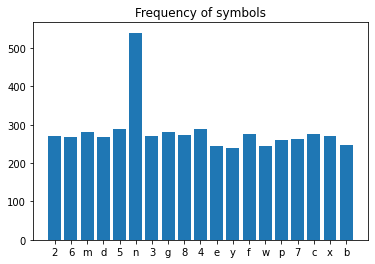

In [2]:
DIR = 'captcha-version-2-images/samples'
captcha_list = []
characters = {}
for captcha in os.listdir(DIR):
    captcha_list.append(captcha)

    captcha_code = captcha.split(".")[0]
    for i in captcha_code:
        characters[i] = characters.get(i, 0) +1
symbols = list(characters.keys())
len_symbols = len(symbols)
print(f'Only {len_symbols} symbols have been used in images')

plt.bar(*zip(*characters.items()))
plt.title('Frequency of symbols')
plt.show()

In [3]:
channels = 1
img_shape = (50, 200, channels)

nSamples = len(captcha_list) # the number of samples 'captchas'
len_captcha = 5

X = np.zeros((nSamples, 50, 200, channels)) # 1070 * 50 * 200
y = np.zeros((5, nSamples, len_symbols)) # 5 * 1070 * 19

In [4]:
for i, captcha in enumerate(captcha_list):
    captcha_code = captcha.split('.')[0]
    captcha_cv2 = cv2.imread(os.path.join(DIR, captcha),cv2.IMREAD_GRAYSCALE)
    captcha_cv2 = captcha_cv2 / 255.0
    
    captcha_cv2 = np.reshape(captcha_cv2, img_shape)
    targs = np.zeros((len_captcha, len_symbols))
    
    for a, b in enumerate(captcha_code):
        targs[a, symbols.index(b)] = 1
    X[i] = captcha_cv2
    y[:, i] = targs

In [5]:
print("shape of X:", X.shape)
print("shape of y:", y.shape)

shape of X: (1070, 50, 200, 1)
shape of y: (5, 1070, 19)


In [6]:
from numpy.random import default_rng

rng = default_rng(seed=1)
test_numbers = rng.choice(1070, size=int(1070*0.3), replace=False)

X_test = X[test_numbers]
X_full = np.delete(X, test_numbers,0)
y_test = y[:,test_numbers]
y_full = np.delete(y, test_numbers,1)

val_numbers = rng.choice(int(1070*0.7), size=int(1070*0.3), replace=False)

X_val = X_full[val_numbers]
X_train = np.delete(X_full, val_numbers,0)
y_val = y_full[:,val_numbers]
y_train = np.delete(y_full, val_numbers,1)

In [7]:
print('Samples in train set:',X_train.shape[0])
print('Samples in test set:',X_test.shape[0])
print('Samples in validation set:',X_val.shape[0])

Samples in train set: 428
Samples in test set: 321
Samples in validation set: 321


In [8]:
aug =iaa.Sequential([iaa.CropAndPad(
    px=((0, 10), (0, 35), (0, 10), (0, 35)),
    pad_mode=['edge'],
    pad_cval=1
),iaa.Rotate(rotate=(-8,8))])



X_aug_train = None
y_aug_train = y_train
for i in range(40):
    X_aug = aug(images = X_train)
    if X_aug_train is not None:
        X_aug_train = np.concatenate([X_aug_train, X_aug], axis = 0)
        y_aug_train = np.concatenate([y_aug_train, y_train], axis = 1)
    else:
        X_aug_train = X_aug
        

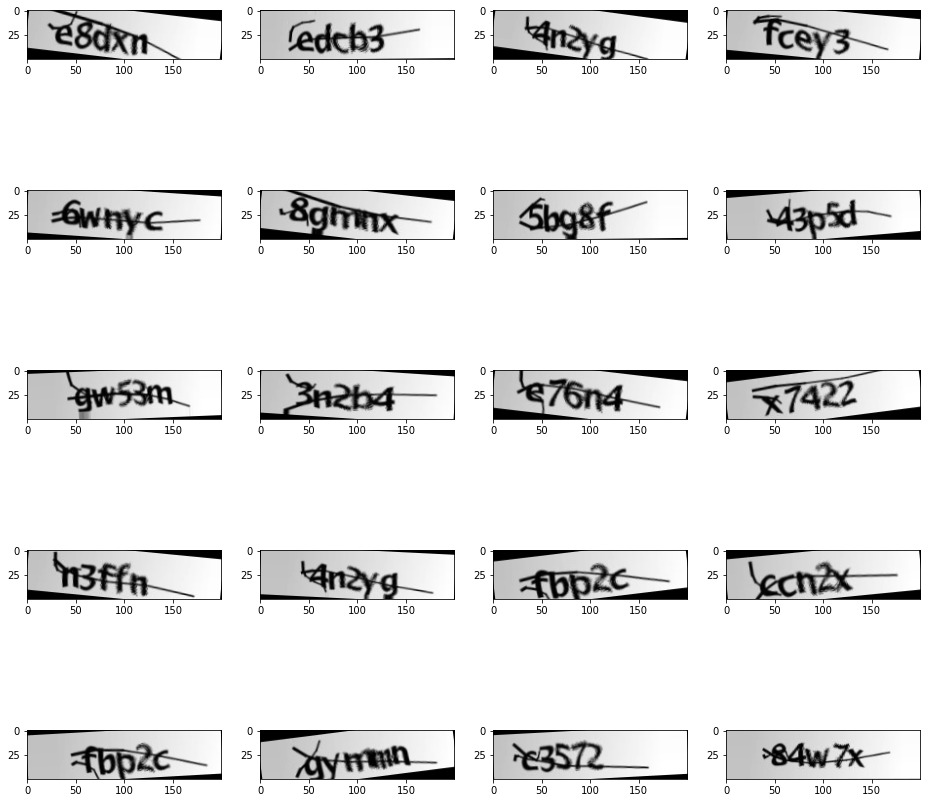

In [9]:
fig, ax = plt.subplots(nrows=5, ncols =4, figsize = (16,16))
for i in range(20):
    index = np.random.randint(X_aug_train.shape[0])
    ax[i//4][i%4].imshow(X_aug_train[index],cmap='gray')

In [10]:
captcha = Input(shape=(50,200,channels))
x = Conv2D(32, (5,5),padding='valid',activation='relu')(captcha)
x = MaxPooling2D((2,2),padding='same')(x)
x = Conv2D(64, (3,3),padding='same',activation='relu')(x)
x = MaxPooling2D((2,2),padding='same')(x)
x = Conv2D(128, (3,3),padding='same',activation='relu')(x)
maxpool = MaxPooling2D((2,2),padding='same')(x)
outputs = []
for i in range(5):
    x = Conv2D(256, (3,3),padding='same',activation='relu')(maxpool)
    x = MaxPooling2D((2,2),padding='same')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(len_symbols , activation='softmax' , name=f'char_{i+1}')(x)
    outputs.append(x)
    
model = Model(inputs = captcha , outputs=outputs)

In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 196, 32)  832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 23, 98, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 23, 98, 64)   18496       max_pooling2d[0][0]              
_______________________________________________________________________________________

In [12]:
reduce_lr = ReduceLROnPlateau(patience =3, factor = 0.5,verbose = 1)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])
earlystopping = EarlyStopping(monitor ="val_loss",  
                             mode ="min", patience = 10,
                              min_delta = 1e-4,
                             restore_best_weights = True) 

# history = model.fit(X_aug_train, [y_aug_train[i] for i in range(5)], batch_size=32, epochs=50, verbose=1, validation_data = (X_val, [y_val[i] for i in range(5)]), callbacks =[earlystopping,reduce_lr])
history = model.fit(X_aug_train, [y_aug_train[i] for i in range(5)], batch_size=16, epochs=30, verbose=1, validation_data = (X_val, [y_val[i] for i in range(5)]), callbacks =[earlystopping,reduce_lr])

Epoch 1/30
1070/1070 [==============================] - 42s 39ms/step - loss: 14.5395 - char_1_loss: 2.9560 - char_2_loss: 2.8933 - char_3_loss: 2.9767 - char_4_loss: 3.0024 - char_5_loss: 2.7113 - char_1_accuracy: 0.1304 - char_2_accuracy: 0.1540 - char_3_accuracy: 0.1360 - char_4_accuracy: 0.1338 - char_5_accuracy: 0.2060 - val_loss: 11.3077 - val_char_1_loss: 2.7621 - val_char_2_loss: 2.1185 - val_char_3_loss: 2.3322 - val_char_4_loss: 2.4266 - val_char_5_loss: 1.6684 - val_char_1_accuracy: 0.2368 - val_char_2_accuracy: 0.3583 - val_char_3_accuracy: 0.2866 - val_char_4_accuracy: 0.1963 - val_char_5_accuracy: 0.4611
Epoch 2/30
1070/1070 [==============================] - 41s 38ms/step - loss: 7.8620 - char_1_loss: 1.6377 - char_2_loss: 1.6306 - char_3_loss: 1.8020 - char_4_loss: 1.7559 - char_5_loss: 1.0357 - char_1_accuracy: 0.5016 - char_2_accuracy: 0.5121 - char_3_accuracy: 0.4526 - char_4_accuracy: 0.4817 - char_5_accuracy: 0.7100 - val_loss: 3.5822 - val_char_1_loss: 0.8195 - va

1070/1070 [==============================] - 41s 38ms/step - loss: 0.3770 - char_1_loss: 0.0780 - char_2_loss: 0.0713 - char_3_loss: 0.0832 - char_4_loss: 0.0895 - char_5_loss: 0.0550 - char_1_accuracy: 0.9762 - char_2_accuracy: 0.9797 - char_3_accuracy: 0.9768 - char_4_accuracy: 0.9730 - char_5_accuracy: 0.9836 - val_loss: 1.4754 - val_char_1_loss: 0.3246 - val_char_2_loss: 0.3087 - val_char_3_loss: 0.4705 - val_char_4_loss: 0.2561 - val_char_5_loss: 0.1155 - val_char_1_accuracy: 0.9408 - val_char_2_accuracy: 0.9315 - val_char_3_accuracy: 0.8754 - val_char_4_accuracy: 0.9502 - val_char_5_accuracy: 0.9688
Epoch 14/30
1070/1070 [==============================] - ETA: 0s - loss: 0.3350 - char_1_loss: 0.0698 - char_2_loss: 0.0673 - char_3_loss: 0.0743 - char_4_loss: 0.0810 - char_5_loss: 0.0425 - char_1_accuracy: 0.9803 - char_2_accuracy: 0.9805 - char_3_accuracy: 0.9786 - char_4_accuracy: 0.9760 - char_5_accuracy: 0.9880
Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00025000

In [13]:
score = model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
metrics = ['loss','char_1_loss', 'char_2_loss', 'char_3_loss', 'char_4_loss', 'char_5_loss', 'char_1_acc', 'char_2_acc', 'char_3_acc', 'char_4_acc', 'char_5_acc']

for i,j in zip(metrics, score):
    print(f'{i}: {j}')

11/11 [==============================] - 0s 20ms/step - loss: 0.8131 - char_1_loss: 0.2246 - char_2_loss: 0.0628 - char_3_loss: 0.2737 - char_4_loss: 0.1910 - char_5_loss: 0.0609 - char_1_accuracy: 0.9408 - char_2_accuracy: 0.9751 - char_3_accuracy: 0.9252 - char_4_accuracy: 0.9595 - char_5_accuracy: 0.9782
loss: 0.8131292462348938
char_1_loss: 0.22462031245231628
char_2_loss: 0.06284461915493011
char_3_loss: 0.2737216353416443
char_4_loss: 0.19100025296211243
char_5_loss: 0.06094231829047203
char_1_acc: 0.940809965133667
char_2_acc: 0.9750778675079346
char_3_acc: 0.9252336621284485
char_4_acc: 0.9595015645027161
char_5_acc: 0.9781931638717651


In [14]:
metrics_df = pd.DataFrame(history.history)

columns = [col for col in metrics_df.columns if 'loss' in col and len(col)>8]

fig = px.line(metrics_df, y = columns)
fig.show()

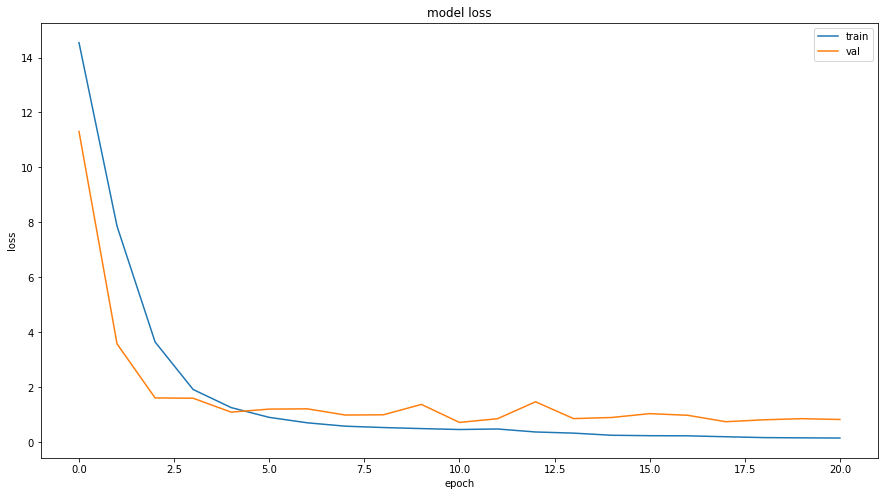

In [15]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right',prop={'size': 10})
plt.show()

In [16]:
def makePredict(captcha):
    captcha = np.reshape(captcha , (1, 50,200,channels))
    result = model.predict(captcha)
    result = np.reshape(result ,(5,len_symbols))
    
    label = ''.join([symbols[np.argmax(i)] for i in result])
    
    return label

In [17]:
actual_pred = []

for i in range(X_test.shape[0]):
    actual = ''.join([symbols[i] for i in (np.argmax(y_test[:, i],axis=1))])
    pred =  makePredict(X_test[i])
    actual_pred.append((actual, pred))

In [18]:
sameCount = 0
diffCount = 0
letterDiff = {i:0 for i in range(5)}
incorrectness = {i:0 for i in range(1,6)}
for real, pred in actual_pred:
    if real == pred:
        sameCount += 1
    else:
        diffCount += 1
        incorrectnessPoint = 0
        for i in range(5):
            if real[i] != pred[i]:
                letterDiff[i] += 1
                incorrectnessPoint += 1
        incorrectness[incorrectnessPoint] += 1

In [19]:
x = ['True predicted', 'False predicted']
y = [sameCount, diffCount]

fig = go.Figure(data=[go.Bar(x = x, y = y)])
fig.show()

In [20]:
x1 = ["Character " + str(x) for x in range(1, 6)]
    
fig = go.Figure(data=[go.Bar(x = x1, y = list(letterDiff.values()))])
fig.show()

In [21]:
x2 = [str(x) + " incorrect" for x in incorrectness.keys()]
y2 = list(incorrectness.values())

fig = go.Figure(data=[go.Bar(x = x2, y = y2)])
fig.show()

IndexError: index 8 is out of bounds for axis 0 with size 8

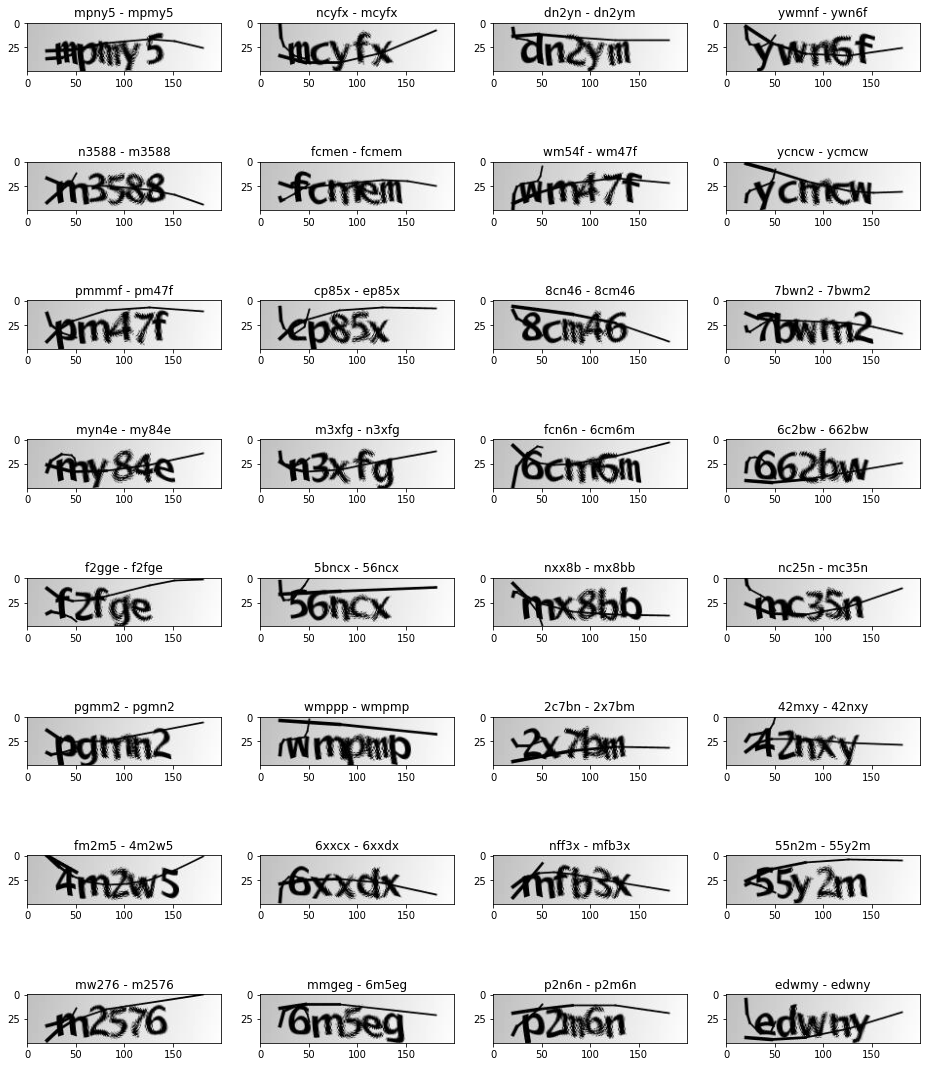

In [22]:
fig, ax = plt.subplots(nrows = 8, ncols=4,figsize = (16,20))
count = 0
for i, (actual , pred) in enumerate(actual_pred):
    if actual != pred:
        img = X_test[i]
        ax[count//4][count%4].imshow(img, cmap = 'gray')
        ax[count//4][count%4].title.set_text(pred + ' - ' + actual)
        count += 1